In [1]:
# import sys, datetime
import serial.tools.list_ports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# from scipy import signal
from scipy.signal import argrelextrema, medfilt
import time, os
from datetime import datetime

In [2]:
# Выбор порта данных с катушек
ports = serial.tools.list_ports.comports()
port = None
# print(ports)
for i, port in enumerate(ports):
    # print(f"{port}")
    print(f"Порт {i}: {port.device}")
    # print(f"Описание: {port.description}")
    # print(f"VID:PID: {port.vid}:{port.pid}")
if port:
    # prt = int(input('Какой порт?'))
    port = ports[0].device
    port_motor = ports[1].device
    print(f'Для получения данных выбран порт - {port}')
    print(f'Для двигателя выбран порт - {port_motor}')

Порт 0: COM6
Порт 1: COM7
Для получения данных выбран порт - COM6
Для двигателя выбран порт - COM7


In [ ]:
# Отправка команды на вращение магнита
with (serial.Serial(port_motor, baudrate=57600, bytesize=8, parity='N', stopbits=1, timeout=0)) as serialData:
    # Read data from COM port
    revolutions = 26
    distance=1000/9
    speed=100
    command = f'ON\rMOVE L(-{int(revolutions * distance)})F({int(speed)})\rOFF\r'
    serialData.write(command.encode(encoding="utf-8"))

# Чтение данных с катушек в память контроллера
time.sleep(3)
with (serial.Serial(port, baudrate=921600, bytesize=8, stopbits=1, timeout=11)) as serialData:
    # Read data from COM port
    command = 'R'
    # Send the command to the DataPort
    serialData.write(command.encode(encoding="utf-8"))
    # serialline.flush()
time.sleep(11)

# Получение данных с выбранного порта в память компьютера
rawdata_bytes = None
with (serial.Serial(port, baudrate=921600, bytesize=8, stopbits=1, timeout=46)) as serialData:
    # Read data from COM port
    command = 'S'
    # Send the command to the DataPort
    serialData.write(command.encode())
    # Get data
    rawdata_bytes = serialData.read(4194304)

In [ ]:
rawdata = np.frombuffer(rawdata_bytes, dtype=np.uint8)

raw_signal = rawdata[:2097152]
# Чтение по два байта (старший-младший) в нотации "big-endian" с переводом в нотацию компилятора (little-endian)
data = raw_signal.view(dtype='>i2').astype(np.int16)

raw_encoder = rawdata[2097152:]
encoder = raw_encoder.view(dtype='>i2').astype(np.int16)

# df_raw = pd.DataFrame({
#     'encoder': encoder,
#     'data': data
# })

# Фильтрация данных от дельта-шумов
window_size = 3
trim_offset = window_size // 2

# Применяем фильтр и обрезаем сразу для обоих столбцов
# Создаем новый DataFrame с отфильтрованными данными
df_filtered = pd.DataFrame({
    'encoder': medfilt(encoder, kernel_size=window_size)[trim_offset:-trim_offset],
    'data': medfilt(data, kernel_size=window_size)[trim_offset:-trim_offset]    
})

In [ ]:
# Перевод данных из битов в целые числа по старому
if 0:
    data = []
    for num in range(0, 2097152, 2):
        hi_byte = rawdata_bytes[num]
        hi_byte = hi_byte if hi_byte < 128 else hi_byte-256
        lo_byte = rawdata_bytes[num+1]    
        data.append(hi_byte*256+lo_byte)
    # print(len(data))

    encoder = []
    for num in range(2097152, len(rawdata_bytes), 2):
        hi_byte = rawdata_bytes[num]
        hi_byte = hi_byte if hi_byte < 128 else hi_byte-256
        lo_byte = rawdata_bytes[num+1]    
        encoder.append(hi_byte*256+lo_byte)
    # print(len(encoder))

    df_raw = pd.DataFrame({'encoder' : encoder, 'data' : data})

,encoder,data
0,2233,6673
1,2233,6673
2,2233,6949
3,2233,6949
4,2234,6947
...,...,...
1048569,4559,1324
1048570,4559,1324
1048571,4559,1424
1048572,4560,1532


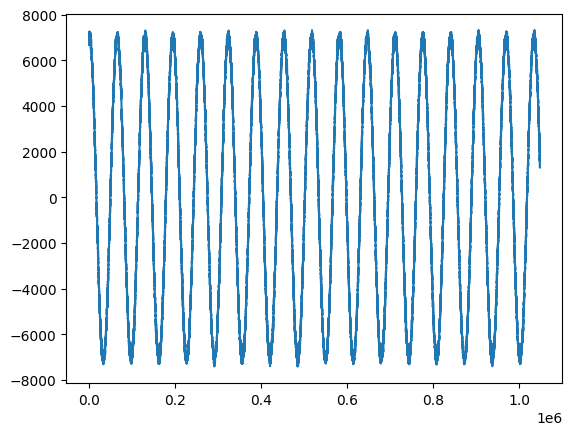

In [ ]:
plt.plot(df_filtered.data)
df_filtered

In [ ]:
# Отрезаем целое число периодов
split_points = df_filtered.index[(df_filtered['encoder'].shift(1) - df_filtered['encoder'] > 1000)]
start_idx = split_points[0]
end_idx = split_points[-1]
df_trimmed = df_filtered.iloc[start_idx:end_idx].copy()

In [ ]:
# Найти индексы, где энкодер "прыгнул"
diff_enc = df_filtered['encoder'].shift(1) - df_filtered['encoder']
split_points = df_filtered.index[diff_enc.abs() > 1000]  # по модулю, чтобы не зависить от направления (?)

print(f'Найдено {len(split_points)-1} периодов энкодера')

if len(split_points) in (0, 1):
    print("Warning: Нет переходов нуля энкодера.")
    df_trimmed = df_filtered.copy()
else:
    start_idx = split_points[0]
    end_idx = split_points[-1]
    # Проверка, чтобы start_idx был меньше end_idx
    if start_idx >= end_idx:
        print(f"Warning: start_idx ({start_idx}) >= end_idx ({end_idx}). Returning original DataFrame.")
        df_trimmed = df_filtered.copy()
    else:
        df_trimmed = df_filtered.iloc[start_idx:end_idx].copy()

Найдено 15 периодов энкодера


In [234]:
df_trimmed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 969021 entries, 50082 to 1019102
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   encoder  969021 non-null  int16
 1   data     969021 non-null  int16
dtypes: int16(2)
memory usage: 3.7 MB


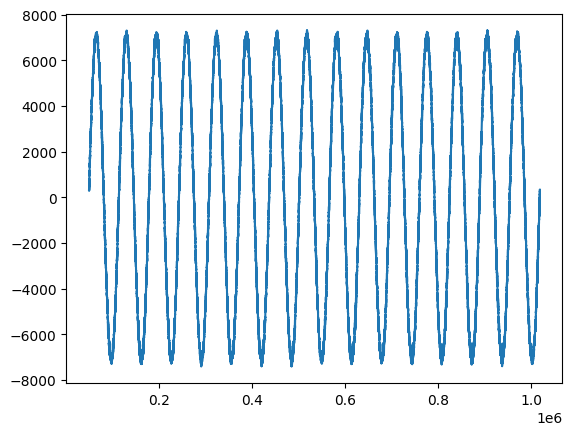

In [225]:
plt.plot(df_trimmed.data)

In [ ]:
if 0:    
    # Усредняем по значениям encoder и вычисляем интеграл по всему периоду данных
    # Добавим столбец, который идентифицирует периоды непрерывных значений encoder
    df_trimmed['period'] = (df_trimmed['encoder'] != df_trimmed['encoder'].shift()).cumsum()

    # Группируем по периоду, затем вычисляем среднее, после чего сбрасываем индекс и период
    df_res = df_trimmed.groupby('period').agg({'data': 'sum', 'encoder': 'max'}).reset_index().drop('period', axis=1)

    df_res['integral'] = -1.0*df_res.data.cumsum()

    # 2.5/32767 - коэф. для перевода в Вольты, 1/96937 в сек (timebase), 1/1144.8 в м (пост катушки), минус из формулы интегрирования
    df_res['volts'] = (2.5/32767 * 1/96937 * 1/1144.8)*df_res.integral

    df_res['deg'] = df_res.index/10000*360

In [ ]:
# Усредняем по значениям encoder и вычисляем интеграл по всему периоду данных
# 1. Группировка по периодам (непрерывные одинаковые значения encoder)
df_trimmed['period'] = (df_trimmed['encoder'] != df_trimmed['encoder'].shift()).cumsum()

# 2. Группируем по периоду, затем вычисляем среднее, после чего сбрасываем индекс и период
df_res = df_trimmed.groupby('period').agg({'data': 'sum', 'encoder': 'first'}).reset_index(drop=True)

# 3. Интеграл (кумулятивная сумма)
# df_res['integral'] = -1.0*df_res.data.cumsum()

from scipy import integrate
dt = 1
df_res['integral'] = -1.0 * integrate.cumulative_trapezoid(df_res['data'], dx=dt, initial=0)

# 4. Пересчет в Вольты*метры*секунды
#  2.5/32767 - коэф. для перевода в Вольты, 1/96937 в сек (timebase), 1/1144.8 в м (пост катушки), минус из формулы интегрирования
df_res['volts'] = (2.5/32767 * 1/96937 * 1/1144.8)*df_res['integral']

# 5. Угол в градусах
df_res['deg'] = (df_res['encoder']/10000)*360

,data,encoder,integral,volts,deg
0,2179,0,-2179.0,-1.498102e-09,0.000
1,2763,1,-4942.0,-3.397714e-09,0.036
2,2062,2,-7004.0,-4.815377e-09,0.072
3,2789,3,-9793.0,-6.732865e-09,0.108
4,2498,4,-12291.0,-8.450285e-09,0.144
...,...,...,...,...,...
149995,1764,9995,36888918.0,2.536180e-05,359.820
149996,2195,9996,36886723.0,2.536029e-05,359.856
149997,2075,9997,36884648.0,2.535886e-05,359.892
149998,1756,9998,36882892.0,2.535766e-05,359.928


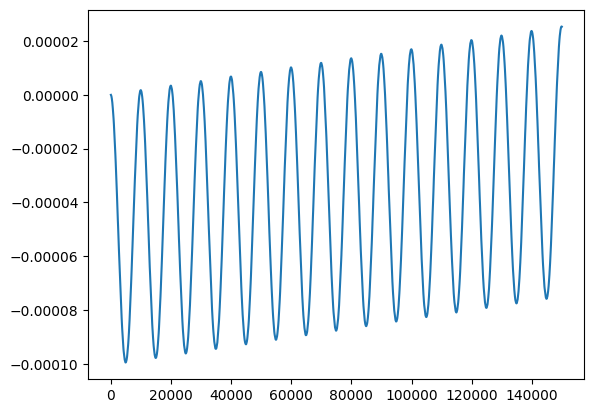

In [35]:
# filename = f"data_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.csv"
# dir = 'data'

# df_res.to_csv(os.path.join(dir, filename))

plt.plot(df_res.volts)
df_res

In [ ]:
import fastgoertzel as fg

norm_freq = 1 / 10000
f_amp, f_phase = fg.goertzel(df_res.volts.values, norm_freq)
# сдвиг рассчитанной фазы на +π/2 и перевод в градусы
f_phase = (f_phase+np.pi/2)*180/np.pi
print(f'Fast Goertzel Amp: {f_amp:.5e}, {f_phase = :.3f}°')

Fast Goertzel Amp: 5.02267e-05, f_phase = 93.580°


In [ ]:
%matplotlib inline

x = df_res.volts.values
y = f_amp * np.sin(2*np.pi * x + f_phase)

t = np.arange(N)  # или np.arange(N) * dt, если нужен реальный масштаб времени
y_reconstructed = amplitude * np.cos(2 * np.pi * f_norm * t + phase_rad)

plt.plot(y)
plt.plot(x)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Пример: f0 — нормированная частота (f_target / fs)
f0_norm = 1 / 10000  # как в вашем случае
N = len(df_res.volts.values)
t = np.arange(N)  # можно использовать реальное время, если оно есть

# Восстановленный сигнал
y_reconstructed = amplitude * np.cos(2 * np.pi * f0_norm * t + phase_rad)

# Построение графиков
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(df_res.volts.values, label='Original Signal (volts)', alpha=0.7)
plt.plot(y_reconstructed, label='Reconstructed Signal', linestyle='--', linewidth=2)
plt.title('Original vs Reconstructed Signal')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(df_res.volts.values - y_reconstructed, label='Residual (Original - Reconstructed)', color='red')
plt.title('Residual Error')
plt.xlabel('Sample Index')
plt.ylabel('Error')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
# Если частота основной гармоники известна (например, f0)
# Предположим, что f0 — это нормированная частота (например, 1/10000, как в вашем примере с goertzel), или вы знаете fs и f0.

# import numpy as np

# Пример: f0 — нормированная частота (f_target / fs)
f0_norm = 1 / 10000  # как в вашем случае
N = len(df_res.volts.values)
n = np.arange(N)

# Вычисляем комплексный коэффициент Фурье
# exp(-j*2*pi*f*n) — базисная функция для частоты f
C = (2 / N) * np.sum(df_res.volts.values * np.exp(-1j * 2 * np.pi * f0_norm * n))

amplitude = abs(C)
phase_rad = np.angle(C)+np.pi/2
phase_deg = phase_rad * 180 / np.pi

print(f'Amplitude: {amplitude:.5e}')
print(f'Phase (rad): {phase_rad:.3f}')
print(f'Phase (deg): {phase_deg:.3f}°')

Amplitude: 5.02267e-05
Phase (rad): 1.633
Phase (deg): 93.580°


In [ ]:
# Если частота неизвестна, и нужно найти основную гармонику
# Выполнить FFT и найти пик:

# import numpy as np

signal = df_res.volts.values
N = len(signal)
fft_vals = np.fft.fft(signal)
freqs = np.fft.fftfreq(N, d=1/96937)  # d=1, если шаг по времени = 1, иначе d=dt

# Находим амплитуду и фазу для частоты с максимальной амплитудой (основная гармоника)
# Ищем только положительные частоты
positive_freqs = freqs[:N//2]
fft_vals_half = fft_vals[:N//2]

# Индекс максимальной амплитуды
max_idx = np.argmax(np.abs(fft_vals_half))

amplitude = 2 * abs(fft_vals_half[max_idx]) / N  # 2/N для амплитуды синусоиды
phase_rad = np.angle(fft_vals_half[max_idx]) + np.pi/2
phase_deg = phase_rad * 180 / np.pi

freq_main = positive_freqs[max_idx]  # частота основной гармоники

print(f'Main frequency: {freq_main}')
print(f'Amplitude: {amplitude:.5e}')
print(f'Phase (deg): {phase_deg:.3f}°')

Main frequency: 0.0
Amplitude: 7.48846e-05
Phase (deg): 270.000°


In [54]:
# 3: Использовать scipy.signal.periodogram или welch
# Если вы хотите оценить спектр и найти пик, scipy предоставляет удобные функции:

from scipy.signal import periodogram
# import numpy as np

fs = 10000  # например, частота дискретизации (или используйте 1, если нормирована)
frequencies, power = periodogram(df_res.volts.values, fs=fs)

max_idx = np.argmax(power)
freq_main = frequencies[max_idx]
amplitude = np.sqrt(power[max_idx]) * 2  # приблизительная амплитуда

# Для фазы всё равно нужно вычислить комплексный коэффициент на freq_main
C = (2 / N) * np.sum(df_res.volts.values * np.exp(-1j * 2 * np.pi * freq_main / fs * np.arange(N)))
phase_rad = np.angle(C) + np.pi/2
phase_deg = phase_rad * 180 / np.pi

print(f'Main frequency: {freq_main}')
print(f'Amplitude: {amplitude:.5e}')
print(f'Phase (deg): {phase_deg:.3f}°')

Main frequency: 1.0
Amplitude: 2.75103e-04
Phase (deg): 93.580°


In [37]:
# df = df_res.copy()
# signal = 'volts'

# PT = 10000 # точек на период
# N = len(df)-len(df)%PT # 150000 количество отсчетов
# # omega0 = 2*np.pi/PT # угловая частота
# k = int(N/PT) # номер гармоники
# alpha = 2*np.cos(2*np.pi*k/N)

# df['s'] = 0.0

# n = 0
# df.loc[n, 's'] = df.loc[n, signal] + alpha*0 - 0
# n = 1
# df.loc[n, 's'] = df.loc[n, signal] + alpha*df.loc[n-1, 's'] - 0

# for n in range(2, len(df)):
#     df.loc[n, 's'] = df.loc[n, signal] + alpha*df.loc[n-1, 's'] - df.loc[n-2, 's']

# F2 = df.loc[N-1, 's']
# F3 = df.loc[N-2, 's']

# real = F2*np.cos(2*np.pi*k/N)-F3
# imag = F2*np.sin(2*np.pi*k/N)

# s_amp = np.sqrt(real**2 + imag**2)*2/N 
# s_phi = (np.arctan2(imag, real)+np.pi/2)*180/np.pi

# # amp = 1/1144.8 * amp # 2.5/32767 - Volts ; 1/96937 - sec ; 1/1144.8 - m

# print(f'Slow Goertzel Amp: {s_amp:.5e}, {s_phi = :.3f}°')

Найдено локальных максимумов: 16
Найдено локальных минимумов: 15
   Амплитуда = 8.25764e-07 ± 1.4e-09
   Относительная погрешность: 0.1637%


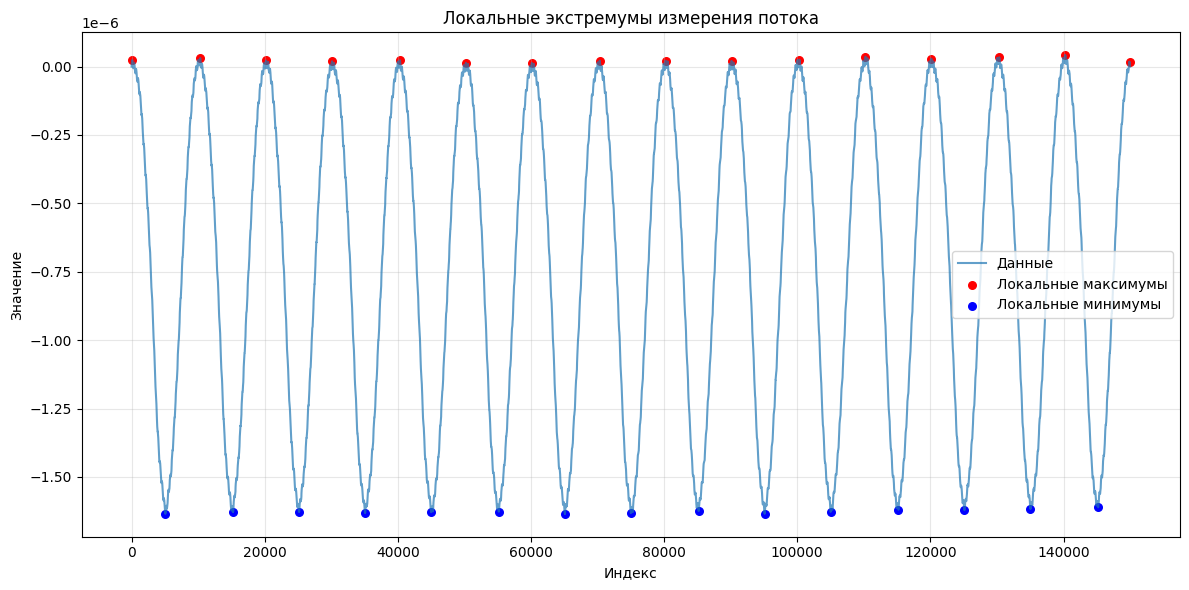

In [38]:
# Находим амплитуду из максимумов
df = df_res.copy()
data_column = 'detrend'

x = df.volts.index.values
y = df.volts.values

# Координаты первой и последней точек
x0, x1 = x[0], x[-1]
y0, y1 = y[0], y[-1]

# Уравнение прямой через две точки: y_trend = a * x + b
a = (y1 - y0) / (x1 - x0) if x1 != x0 else 0
b = y0 - a * x0

# Вычисляем трендовую составляющую и вычитаем
trend = a * x + b
df[data_column] = (y - trend)

# Локальные максимумы
local_maxima = argrelextrema(df[data_column].values, np.greater, order=1000)[0]
# Локальные минимумы
local_minima = argrelextrema(df[data_column].values, np.less, order=1000)[0]

print(f"Найдено локальных максимумов: {len(local_maxima)}")
print(f"Найдено локальных минимумов: {len(local_minima)}")

# Добавляем метки в DataFrame
df['is_local_max'] = False
df['is_local_min'] = False

df.loc[local_maxima, 'is_local_max'] = True
df.loc[local_minima, 'is_local_min'] = True

# Извлечение экстремумов
maxima = df[df['is_local_max']]
minima = df[df['is_local_min']]

# Вычисляем средние значения
mean_max = maxima[data_column].mean()
mean_min = minima[data_column].mean()

# Разность средних
amplitude = (mean_max - mean_min)/2

# 3. Вычисляем погрешности
# Погрешность среднего значения максимумов
std_max = maxima[data_column].std(ddof=1)
std_error_max = std_max / np.sqrt(len(maxima))

# Погрешность среднего значения минимумов
std_min = minima[data_column].std(ddof=1)
std_error_min = std_min / np.sqrt(len(minima))

# Абсолютная погрешность амплитуды (по формуле погрешности разности)
absolute_error = np.sqrt(std_error_max**2 + std_error_min**2) / 2

# Относительная погрешность амплитуды
relative_error = absolute_error / amplitude * 100  # в процентах

print(f"   Амплитуда = {amplitude:.5e} ± {absolute_error:.2}")
print(f"   Относительная погрешность: {relative_error:.4f}%")

%matplotlib inline
data_column = 'detrend'

plt.figure(figsize=(12, 6))
plt.plot(df.index, df[data_column], label='Данные', alpha=0.7)
plt.scatter(local_maxima, df.loc[local_maxima, data_column], 
           color='red', label='Локальные максимумы', s=30)
plt.scatter(local_minima, df.loc[local_minima, data_column], 
           color='blue', label='Локальные минимумы', s=30)
plt.xlabel('Индекс')
plt.ylabel('Значение')
plt.title('Локальные экстремумы измерения потока')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('extrema_plot.png', dpi=300)
plt.show()

In [10]:
Goertzel_Amp1 = 5.02492e-05
Goertzel_Amp2 = 5.07023e-05
Goertzel_Amp3 = 9.35180e-07

amps1 = [Goertzel_Amp1, Goertzel_Amp2, Goertzel_Amp3]

f_phase1 = 93.697
f_phase2 = 181.772
f_phase3 = 120.873

PeakAmp1 = 5.01997e-05
PeakAmp2 = 5.01941e-05
PeakAmp3 = 8.25764e-07

amps2 = [PeakAmp1, PeakAmp2, PeakAmp3]

# Измерение 1:   5.02003e-05 ± 5e-09 (0.01%) [В*с*м]
# Измерение 2:   5.01836e-05 ± 7e-08 (0.13%) [В*с*м]
# Измерение 3:   8.23969e-07 ± 1e-09 (0.16%) [В*с*м]
# Полный момент: 5.02e-05 [В*с*м]; Отклонение от нормали θz: 1.33°

In [13]:
import numpy as np

for amps in [amps1, amps2]:
    """Получить финальный результат измерений"""
    # Извлекаем амплитуды из всех трех измерений
    amplitudes = sorted(amps)

    # Вычисляем финальный результат по формуле
    sum_of_squares = sum(amp**2 for amp in amplitudes) / 2
    final_amplitude = np.sqrt(sum_of_squares)

    print(f'{final_amplitude:.5}') # {((final_amplitude - 5.02e-05)/final_amplitude * 100):.2}%

    # Угол отклонения от нормали (оси z)
    M_xy, M_yz, M_zx = amplitudes

    theta_rad = np.arctan(M_xy / (np.sqrt(M_yz**2 + M_zx**2 - M_xy**2)/2))
    theta_deg = np.degrees(theta_rad)

    print(f'{theta_deg:.3}')

5.0481e-05
1.5
5.02e-05
1.33


In [15]:
f'Разница - {((5.05e-05 - 5.02e-05)/5.05e-05 * 100):.2}%'

'Разница - 0.59%'

- 5.020e-05 1.33°
- 5.048e-05 1.50°